In [358]:
import numpy as np
import pandas as pd

# 2. Grouping Users together!

Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

### 2.1 Getting your data + feature engineering

1. Access to the data

In [359]:
df = pd.read_csv('vodclickstream_uk_movies_03.csv')

2. Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

a) Favorite genre:

We begin with the favourite genre of the user. For this we are going to do a quick search, separating the genre columns in a string a creating a new row for each genre. Then search for the one who has te most cumulative duration.

In [360]:
df_final = df 

# We split and create a new row for each genre with explode
df_final['genres'] = df_final['genres'].astype(str).str.split(',')
exploded_df = df_final.explode('genres')

# We convert the genres to lowercase and strip them
exploded_df['genres'] = exploded_df['genres'].str.lower().str.strip()

# We group by user_id and genres and we get the sum of duration
group_df = exploded_df.groupby(['user_id', 'genres'])['duration'].sum().reset_index()

# We find the genre with the longest duration for each user
idx = group_df.groupby('user_id')['duration'].idxmax()
favorite_genre = group_df.loc[idx, ['user_id', 'genres']].reset_index(drop=True)
favorite_genre.columns = ['user_id', 'favorite_genre']


In [361]:
df_final = pd.merge(df, favorite_genre, on='user_id', how='left')


b) Average click duration

Here we are going to group by user_id and then calculate the mean of the duration

In [362]:
mean_duration = df.groupby('user_id')['duration'].mean() # We use the gorupby and mean function
df_average_duration = mean_duration.reset_index(name='average_click_duration')


In [363]:
df_final = pd.merge(df_final, df_average_duration, on='user_id', how='left') # we merge the new values


c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

For this we first convert datetime to only get the hour of the day, and the we create the time of the day it belongs.

In [364]:
# Convert 'datetime' to datetime format
df_final['hour_of_day'] = pd.to_datetime(df_final['datetime'])

# Extract the time from the 'datetime' column
df_final['hour_of_day'] = df_final['hour_of_day'].dt.time



We will define the morning from 6 am to 12 pm, the afternoon from 12pm to 7 pm, and the night from 7 pm to 6 am.

In [365]:
# We extract the hour and create the time of day for each click.
df_final['time_of_day'] = pd.cut(df_final['hour_of_day'].apply(lambda x: x.hour), bins=[0, 6, 12, 19, 24], labels=['Night', 'Morning', 'Afternoon', 'Night'], right=False, ordered=False)

Once we have this information we need to see wich one is the one the user spent the most time. For this we do like we did before for favorite genre and we get the one with the highest sum value.

In [366]:
# We group by user_id and times of day and we get the sum of duration
group_td = df_final.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()

# We find the genre with the longest duration for each user
idx = group_td.groupby('user_id')['duration'].idxmax()
most_spent = group_td.loc[idx, ['user_id', 'time_of_day']].reset_index(drop=True)
most_spent.columns = ['user_id', 'tod_most_spent']

C:\Users\HP\AppData\Local\Temp\ipykernel_12380\4259249813.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_td = df_final.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()


In [367]:
df_final = pd.merge(df_final, most_spent, on='user_id', how='left') # we merge the new values


d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

For this one we define first a new column where if the release date is posterior to the 2000 it will be define as recent (1) and if its anterior it will be defined as old (0).

In [368]:
# Convert 'release_date' to datetime with errors='coerce'
df_final['release_date'] = pd.to_datetime(df_final['release_date'], errors='coerce')

# Create 'is_recent' column based on the release date
df_final['recent_movie'] = (df_final['release_date'].dt.year >= 2000).astype(int)


Now we group by user and by recent movie and we sum the duration as we did before.

In [369]:
# We group by user_id and times of day and we get the sum of duration
group_rm = df_final.groupby(['user_id', 'recent_movie'])['duration'].sum().reset_index()

# We find the genre with the longest duration for each user
idx = group_rm.groupby('user_id')['duration'].idxmax()
old_new_lover = group_rm.loc[idx, ['user_id', 'recent_movie']].reset_index(drop=True)
old_new_lover.columns = ['user_id', 'old/new_movie_lover']

In [370]:
df_final = pd.merge(df_final, old_new_lover, on='user_id', how='left') # we merge the new values


Here the first five are recent movie lover

e) Average time spent a day by the user (considering only the days he logs in)

For this feature we will get first the date and get the mean duration by user id and by date

In [371]:
# We convert datetime to datetime format
df_final['datetime'] = pd.to_datetime(df_final['datetime'])

# We extract the date from datetime
df_final['date'] = df_final['datetime'].dt.date


Now we group and get the mean by date

In [372]:
mean_tpd = df_final.groupby(['user_id', 'date'])['duration'].sum().groupby('user_id').mean()
df_mean_tpd = mean_tpd.reset_index(name='average_tpd')


In [373]:
df_final = pd.merge(df_final, df_mean_tpd, on='user_id', how='left') # we merge the new values



Lets take a look t our results

In [374]:
df_final.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,hour_of_day,time_of_day,tod_most_spent,recent_movie,old/new_movie_lover,date,average_tpd
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,0.000000,01:15:09,Night,Afternoon,1,1,2017-01-01,0.000000
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,1553.750000,13:56:02,Afternoon,Night,1,1,2017-01-01,18645.000000
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,4218.666667,15:17:47,Afternoon,Afternoon,1,1,2017-01-01,8437.333333
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,1883.533333,16:04:13,Afternoon,Afternoon,1,1,2017-01-01,9417.666667
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,3684.538462,19:16:37,Night,Afternoon,1,1,2017-01-01,7369.076923


Now we have 5 new features for each user_id.  This will probably help us to understand the behavior of the users and group them. But it's not enough yet.

We do have some more that we will eliminate later. But we will keep them for the moment since we are going to use them for the next features engineering.

##### Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

1st one: Total different shows watched (more than 5 minutes of duration).

We should groub by all the users and different tiltes, sum the duration and make a count.

In [375]:

# Grouping the DataFrame by 'user_id' and 'title', calculating the total 'duration' for each combination
group_ws = df_final.groupby(['user_id', 'title'])['duration'].sum().reset_index()

# Selecting rows where the total 'duration' for each user and title is greater than 300
filtered_df = group_ws[group_ws['duration'] > 300]

# Counting the number of unique 'title' values for each user
total_watched_count_shows = filtered_df.groupby('user_id')['title'].nunique().reset_index(name='watched_shows')


In [376]:
df_final = pd.merge(df_final, total_watched_count_shows, on='user_id', how='left')


We have to fill the NaN with 0 values.

In [377]:
df_final['watched_shows'] = df_final['watched_shows'].fillna(0)

2nd features: Total different shows.

We can do the same with all the different shows clicked, so we can compare them with the watched one.

This one is easier, we just have to count the diferrent title values for each user.

In [378]:
total_movies_count = df_final.groupby('user_id')['title'].nunique().reset_index(name='total_shows')


In [379]:
df_final = pd.merge(df_final, total_movies_count, on='user_id', how='left')



3rd feature: different genres clicked

Lets now get the different genres the user has clicked. We will use the nunique function that will get all the different genres for one user.

We are going to use the exploded_df we use for the prefered genre.

In [380]:
dif_genres = exploded_df.groupby('user_id')['genres'].nunique().reset_index(name='dif_genres')
dif_genres

,user_id,dif_genres
0,00004e2862,3
1,000052a0a0,14
2,000090e7c8,3
3,000118a755,2
4,000296842d,4
...,...,...
161913,fffd9bf758,3
161914,fffe7b777b,3
161915,fffeac83be,9
161916,ffff2c5f9e,5


In [381]:
df_final = pd.merge(df_final, dif_genres, on='user_id', how='left')


4th feature: Average release year of the clicked shows

Lets see what  is the average year of the shows seen by each user. For this we are going to group by user and release date, and get the mean of all the releases fromm the movies and shows clicked by the user.

In [382]:

average_release_year = df_final.groupby('user_id')['release_date'].agg(lambda x: np.floor(x.dt.year.mean())).reset_index(name='average_release_year')


In [383]:
df_final = pd.merge(df_final, average_release_year, on='user_id', how='left')


5th feature: different days active.

Here we are going to get all the days the user has connected to netflix during this period.

We are just going to count the differents dates as we did with the different genres.

In [384]:
days_active = df_final.groupby('user_id')['date'].nunique().reset_index(name='days_active')


In [385]:
df_final = pd.merge(df_final, days_active, on='user_id', how='left')


6th feature: most clicked genre.

We do as for the most favorite but we don't sum the duration, we count the times it appears.

In [386]:

most_clicked_genre = exploded_df.groupby('user_id')['genres'].agg(lambda x: x.value_counts().idxmax()).reset_index(name='most_clicked_genre')




In [387]:
df_final = pd.merge(df_final, most_clicked_genre, on='user_id', how='left')



7th feature: preffered day of the week

Here we are going to see what is the day of the week the user watch modt of the shows. 

We are going to group by date and user id, and sum the duration for each week day. This way we will know wich one has the longest duration and the one the user spends most of the time.

In [388]:
# we convert date to datetime format
df_final['date'] = pd.to_datetime(df_final['date'])

# We group by user and the day name of the date summing the durations
group_day = df_final.groupby(['user_id', df_final['date'].dt.day_name()])['duration'].sum().reset_index()

# We find the index with the maximum duration for each user_id
max_duration_idx = group_day.groupby('user_id')['duration'].idxmax()

# Use the indices to get the corresponding day names
preferred_day = group_day.loc[max_duration_idx, ['user_id', 'date']]

# We rename the columns
preferred_day.columns = ['user_id', 'preferred_day']


In [389]:
df_final = pd.merge(df_final, preferred_day, on='user_id', how='left')


8th feature: average time between clicks.

Lets see how long it takes the users to click. This way we will know which one are the one that use more the product.

We first have to get the time between consecutif clicks

In [390]:
df_final['time_between_clicks'] = df_final.sort_values(['user_id', 'datetime']).groupby('user_id')['datetime'].diff().dt.total_seconds()


Now that we have the time between clicks we can calculate the mean by making a group by user_id and time_between_clicks

In [391]:
mean_t_between_clicks = df_final.groupby('user_id')['time_between_clicks'].mean().reset_index(name='average_t_between_clicks')


In [392]:
df_final = pd.merge(df_final, mean_t_between_clicks, on='user_id', how='left')


We don't forget to fill the NaN values

In [393]:
df_final['average_t_between_clicks'] = df_final['average_t_between_clicks'].fillna(0)

9th feature: Weekend viewer

With this feature we will see if the user is more of a weekend user or of a week day user.

In [394]:
df_final['weekend_viewer'] = df_final['preferred_day'].isin(['Saturday', 'Sunday']).astype(int)


10th feature: total duration 

Here we will get the total duration of the users, so we can compare them.

We will just sum the duration for each user.

In [395]:
df_final['total_duration'] = df_final.groupby('user_id')['duration'].transform('sum')


Lets take a look to our final dataframe.

In [396]:
df_final.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,...,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,time_between_clicks,average_t_between_clicks,weekend_viewer,total_duration
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,0.000000,...,1,3,2008.0,1,comedy,Sunday,NaN,0.000000,1,0.0
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,1553.750000,...,8,8,2012.0,1,romance,Sunday,NaN,2669.181818,1,18645.0
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,4218.666667,...,4,9,2013.0,3,action,Sunday,NaN,54521.600000,1,25312.0
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,1883.533333,...,12,11,2011.0,3,action,Sunday,1569.0,43720.500000,1,28253.0
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,3684.538462,...,22,21,2010.0,13,drama,Monday,3036.0,113215.360000,0,95798.0


We will clean the dataframe with the features we are interested for each user.

In [397]:
definitive_df = df_final
definitive_df.drop(columns=['time_between_clicks','date','hour_of_day','time_of_day'], inplace=True)

In [398]:
definitive_df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,...,watched_shows,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,average_t_between_clicks,weekend_viewer,total_duration
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,0.000000,...,0.0,1,3,2008.0,1,comedy,Sunday,0.000000,1,0.0
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,1553.750000,...,2.0,8,8,2012.0,1,romance,Sunday,2669.181818,1,18645.0
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,4218.666667,...,2.0,4,9,2013.0,3,action,Sunday,54521.600000,1,25312.0
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,1883.533333,...,8.0,12,11,2011.0,3,action,Sunday,43720.500000,1,28253.0
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,3684.538462,...,9.0,22,21,2010.0,13,drama,Monday,113215.360000,0,95798.0


In [399]:
# Assuming 'definitive_df' is the DataFrame you want to export
definitive_df.to_csv('final_features.csv', index=False)


In [402]:
definitive_df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,...,watched_shows,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,average_t_between_clicks,weekend_viewer,total_duration
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,0.000000,...,0.0,1,3,2008.0,1,comedy,Sunday,0.000000,1,0.0
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,1553.750000,...,2.0,8,8,2012.0,1,romance,Sunday,2669.181818,1,18645.0
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,4218.666667,...,2.0,4,9,2013.0,3,action,Sunday,54521.600000,1,25312.0
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,1883.533333,...,8.0,12,11,2011.0,3,action,Sunday,43720.500000,1,28253.0
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,3684.538462,...,9.0,22,21,2010.0,13,drama,Monday,113215.360000,0,95798.0


### 2.2 Choose your features (variables)!


Now that we have all our features, it would be best to find a way to reduce the dimensionality.

1. To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing the features. 

With our data, the best will be to normalize our feature, but we can only do that with our numerical features, since the categoricals needed to be trated in another way.

So lets first define our numerical features that we want to normalise. These are all that are continuous and are no binary. that's why the date cannot be normalise, nor the columns like 'weekend_viewer'

In [403]:
numerical_features = ['duration', 'average_click_duration', 'average_tpd', 'total_shows', 'watched_shows','dif_genres', 'days_active', 'average_t_between_clicks', 'total_duration']

In [404]:
from sklearn.preprocessing import StandardScaler

Lets normalise our features

In [405]:
standard_scaler = StandardScaler()

df_norm = definitive_df
df_norm[numerical_features] = standard_scaler.fit_transform(df_norm[numerical_features])


Lets take a look

In [423]:
df_norm.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,...,watched_shows,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,average_t_between_clicks,weekend_viewer,total_duration
0,58773,2017-01-01 01:15:09,-0.212628,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,-0.331483,...,-0.594913,-0.594728,-1.257735,2008.0,-0.736989,comedy,Sunday,-0.597879,1,-0.511934
1,58774,2017-01-01 13:56:02,-0.212628,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,-0.316098,...,-0.372986,-0.092831,-0.157035,2012.0,-0.736989,romance,Sunday,-0.589830,1,-0.482454
2,58775,2017-01-01 15:17:47,-0.145745,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,-0.289710,...,-0.372986,-0.379629,0.063105,2013.0,-0.459760,action,Sunday,-0.433469,1,-0.471913
3,58776,2017-01-01 16:04:13,-0.212317,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,-0.312832,...,0.292797,0.193968,0.503385,2011.0,-0.459760,action,Sunday,-0.466040,1,-0.467263
4,58777,2017-01-01 19:16:37,-0.212628,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,-0.294999,...,0.403761,0.910964,2.704785,2010.0,0.926389,drama,Monday,-0.256478,0,-0.360467


2. Select one method for dimensionality reduction and apply it to your data.

For the dimensionality reduction we are going to use the FAMD method, that takes in account numerical and categorical features.

We first drop all the Nan values of our dataset

In [415]:
df_norm=df_norm.dropna()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,...,watched_shows,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,average_t_between_clicks,weekend_viewer,total_duration
0,58773,2017-01-01 01:15:09,-0.212628,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,-0.331483,...,-0.594913,-0.594728,-1.257735,2008.0,-0.736989,comedy,Sunday,-0.597879,1,-0.511934
1,58774,2017-01-01 13:56:02,-0.212628,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,-0.316098,...,-0.372986,-0.092831,-0.157035,2012.0,-0.736989,romance,Sunday,-0.589830,1,-0.482454
2,58775,2017-01-01 15:17:47,-0.145745,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,-0.289710,...,-0.372986,-0.379629,0.063105,2013.0,-0.459760,action,Sunday,-0.433469,1,-0.471913
3,58776,2017-01-01 16:04:13,-0.212317,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,-0.312832,...,0.292797,0.193968,0.503385,2011.0,-0.459760,action,Sunday,-0.466040,1,-0.467263
4,58777,2017-01-01 19:16:37,-0.212628,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,-0.294999,...,0.403761,0.910964,2.704785,2010.0,0.926389,drama,Monday,-0.256478,0,-0.360467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,-0.207223,Oprah Presents When They See Us Now,[Talk-Show],2019-06-12,43cd23f30f,57501964fd,talk-show,-0.323057,...,-0.483949,-0.594728,-1.698015,2019.0,-0.736989,talk-show,Sunday,-0.597879,1,-0.510588
671732,730505,2019-06-30 21:49:34,0.366369,HALO Legends,"[Animation, Action, Adventure, Family, Sci...",2010-02-16,febf42d55f,d4fcb079ba,action,-0.108355,...,-0.151058,0.050569,0.063105,2012.0,-0.043915,action,Sunday,-0.360016,1,-0.084401
671733,730506,2019-06-30 22:00:44,-0.212628,Pacific Rim,"[Action, Adventure, Sci-Fi]",2013-07-12,7b15e5ada1,4a14a2cd5a,drama,-0.326508,...,-0.483949,-0.236230,0.063105,2017.0,-0.321145,action,Sunday,-0.423357,1,-0.503989
671734,730507,2019-06-30 22:04:23,-0.212628,ReMastered: The Two Killings of Sam Cooke,"[Documentary, Music]",2019-02-08,52d49c515a,0b8163ea4b,comedy,-0.182239,...,-0.372986,-0.307929,0.063105,2017.0,-0.459760,documentary,Saturday,0.509168,1,-0.392782


In [428]:
df_grouped = df_norm[['user_id','favorite_genre', 'average_click_duration','tod_most_spent',
                     'recent_movie', 'old/new_movie_lover', 'average_tpd', 'watched_shows', 'total_shows',  
                     'dif_genres','average_release_year','days_active', 'most_clicked_genre', 'preferred_day',
                     'average_t_between_clicks','weekend_viewer','total_duration']]

df_groupes= df_grouped.drop_duplicates()
df_groupes

,user_id,favorite_genre,average_click_duration,tod_most_spent,recent_movie,old/new_movie_lover,average_tpd,watched_shows,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,average_t_between_clicks,weekend_viewer,total_duration
0,1dea19f6fe,comedy,-0.331483,Afternoon,1,1,-0.392327,-0.594913,-0.594728,-1.257735,2008.0,-0.736989,comedy,Sunday,-0.597879,1,-0.511934
1,544dcbc510,drama,-0.316098,Night,1,1,-0.259410,-0.372986,-0.092831,-0.157035,2012.0,-0.736989,romance,Sunday,-0.589830,1,-0.482454
2,7cbcc791bf,action,-0.289710,Afternoon,1,1,-0.332179,-0.372986,-0.379629,0.063105,2013.0,-0.459760,action,Sunday,-0.433469,1,-0.471913
3,ebf43c36b6,action,-0.312832,Afternoon,1,1,-0.325190,0.292797,0.193968,0.503385,2011.0,-0.459760,action,Sunday,-0.466040,1,-0.467263
4,a57c992287,drama,-0.294999,Afternoon,1,1,-0.339794,0.403761,0.910964,2.704785,2010.0,0.926389,drama,Monday,-0.256478,0,-0.360467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671705,783ec67e84,biography,-0.331483,Afternoon,1,1,-0.392327,-0.594913,-0.594728,-1.257735,2009.0,-0.736989,biography,Sunday,-0.597879,1,-0.511934
671714,cb90425707,sci-fi,-0.250922,Night,0,1,-0.295663,0.181833,0.050569,1.604085,2013.0,-0.043915,action,Tuesday,0.156124,0,-0.383298
671727,89c715f3a4,adventure,-0.331493,Afternoon,1,1,-0.392334,-0.594913,-0.594728,-0.597315,2017.0,-0.736989,animation,Sunday,-0.597879,1,-0.511936
671730,9207e1499b,biography,0.090267,Night,1,1,-0.088697,-0.483949,-0.594728,-1.257735,2013.0,-0.736989,biography,Sunday,-0.597879,1,-0.444591


In [429]:
import pandas as pd
from prince import FAMD


# We select features for FAMD (both numerical and categorical)
features_for_famd = ['favorite_genre', 'average_click_duration','tod_most_spent',
                     'recent_movie', 'old/new_movie_lover', 'average_tpd', 'watched_shows', 'total_shows',  
                     'dif_genres','average_release_year','days_active', 'most_clicked_genre', 'preferred_day',
                     'average_t_between_clicks','weekend_viewer','total_duration']

df_famd = df_groupes[features_for_famd]

# Applying FAMD
famd = FAMD(n_components=5, n_iter=10,random_state=10)  # Choose the number of components based on your requirements
df_famd_result = famd.fit_transform(df_famd)

# # Display the DataFrame with FAMD components
print(df_famd_result)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.9897454884646965, -0.5112676093031033, -0.1727945318593479, -0.39950285364239285, -0.9015782875162537, -0.4142044827774414, -0.5081459823862632, -0.6966134257687303, -0.12218418522969983, -0.13229610345605933, -0.004432086226159486, -0.050143331605133866, -0.2877103376038105, -0.0625222702315456, -0.03133958225320867, -0.11142092000958878, -0.006267916450641733, -0.2549123938722882, -0.08220295360108872, -0.1858307742536903, -0.16482356033402434, -0.043198632964836975, -0.03838299263617217, -0.02259929415311302, -0.25464254324736824, -0.03734542234925181, -0.05517902852531437, -0.9109527646448953, -0.4071734242162553, -0.350695386692185, -0.301381863378845, -0.9250115413666739, -0.35506515770040126, -0.5673416615654289, -0.7832387995446839, -0.12929239520

component         0         1          2         3           4
0         -0.082036  4.004205   0.767174 -0.540879   -0.922372
1          2.326532  3.103562  -2.199272  0.912337    2.860671
2         -3.100252  3.116474  -2.676366 -0.832248   -0.805774
3         -2.468935  3.042232  -3.078906 -0.695185   -0.585715
4          3.165057 -2.194035  -2.660374  1.533723    2.567664
...             ...       ...        ...       ...         ...
671705    -4.447819  4.183600   4.076814 -0.883130    3.419522
671714     2.505737 -2.796928  -3.500313  0.635499    0.319937
671727    -1.953976  3.949367   0.173044 -1.586914   -3.639599
671730    -3.672006  3.938231   3.502550 -0.572537    3.964385
671731    -6.596512  2.198029  12.043004 -4.482912  118.945450

[178177 rows x 5 columns]


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.9897454884646965, -0.5112676093031033, -0.1727945318593479, -0.39950285364239285, -0.9015782875162537, -0.4142044827774414, -0.5081459823862632, -0.6966134257687303, -0.12218418522969983, -0.13229610345605933, -0.004432086226159486, -0.050143331605133866, -0.2877103376038105, -0.0625222702315456, -0.03133958225320867, -0.11142092000958878, -0.006267916450641733, -0.2549123938722882, -0.08220295360108872, -0.1858307742536903, -0.16482356033402434, -0.043198632964836975, -0.03838299263617217, -0.02259929415311302, -0.25464254324736824, -0.03734542234925181, -0.05517902852531437, -0.9109527646448953, -0.4071734242162553, -0.350695386692185, -0.301381863378845, -0.9250115413666739, -0.35506515770040126, -0.5673416615654289, -0.7832387995446839, -0.12929239520

Lets try and plot the first two components to see what it looks like

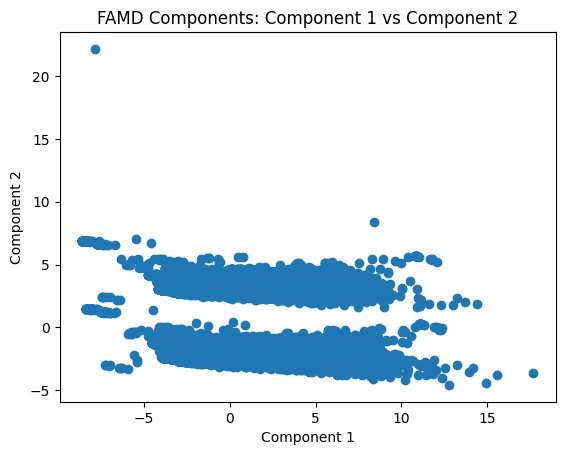

In [448]:
import matplotlib.pyplot as plt

# Assuming df_famd_result has columns 'Component 0' and 'Component 1'
plt.scatter(df_famd_result.iloc[:, 0], df_famd_result.iloc[:, 1])
plt.title('FAMD Components: Component 1 vs Component 2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


We can clearly see two groups 

Lets study the inertia of the reduction to understand better how many componetns we need

In [449]:
famd = FAMD(n_components=5, n_iter=10,random_state=10)
famd_fit=famd.fit(df_famd)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.9897454884646965, -0.5112676093031033, -0.1727945318593479, -0.39950285364239285, -0.9015782875162537, -0.4142044827774414, -0.5081459823862632, -0.6966134257687303, -0.12218418522969983, -0.13229610345605933, -0.004432086226159486, -0.050143331605133866, -0.2877103376038105, -0.0625222702315456, -0.03133958225320867, -0.11142092000958878, -0.006267916450641733, -0.2549123938722882, -0.08220295360108872, -0.1858307742536903, -0.16482356033402434, -0.043198632964836975, -0.03838299263617217, -0.02259929415311302, -0.25464254324736824, -0.03734542234925181, -0.05517902852531437, -0.9109527646448953, -0.4071734242162553, -0.350695386692185, -0.301381863378845, -0.9250115413666739, -0.35506515770040126, -0.5673416615654289, -0.7832387995446839, -0.12929239520

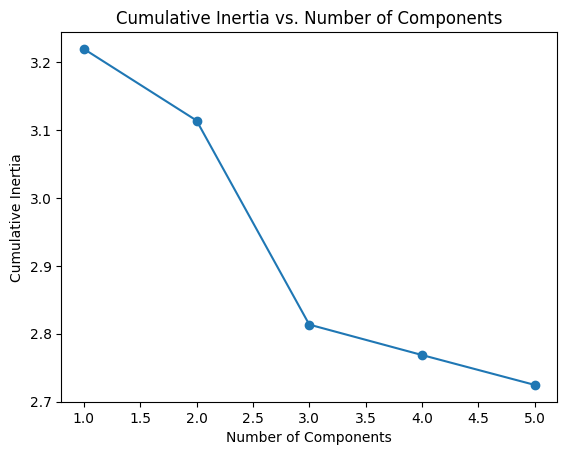

In [451]:
import pandas as pd
from prince import FAMD
import matplotlib.pyplot as plt


cumulative_inertia = famd_fit.percentage_of_variance_

# Plotting the cumulative inertia
plt.plot(range(1, 6), cumulative_inertia, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Inertia')
plt.title('Cumulative Inertia vs. Number of Components')
plt.show()

We see that we have an elbow for number of components equal 3.

Lets plot all the combination of the components to see if we have more groups formed.

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.9897454884646965, -0.5112676093031033, -0.1727945318593479, -0.39950285364239285, -0.9015782875162537, -0.4142044827774414, -0.5081459823862632, -0.6966134257687303, -0.12218418522969983, -0.13229610345605933, -0.004432086226159486, -0.050143331605133866, -0.2877103376038105, -0.0625222702315456, -0.03133958225320867, -0.11142092000958878, -0.006267916450641733, -0.2549123938722882, -0.08220295360108872, -0.1858307742536903, -0.16482356033402434, -0.043198632964836975, -0.03838299263617217, -0.02259929415311302, -0.25464254324736824, -0.03734542234925181, -0.05517902852531437, -0.9109527646448953, -0.4071734242162553, -0.350695386692185, -0.301381863378845, -0.9250115413666739, -0.35506515770040126, -0.5673416615654289, -0.7832387995446839, -0.12929239520

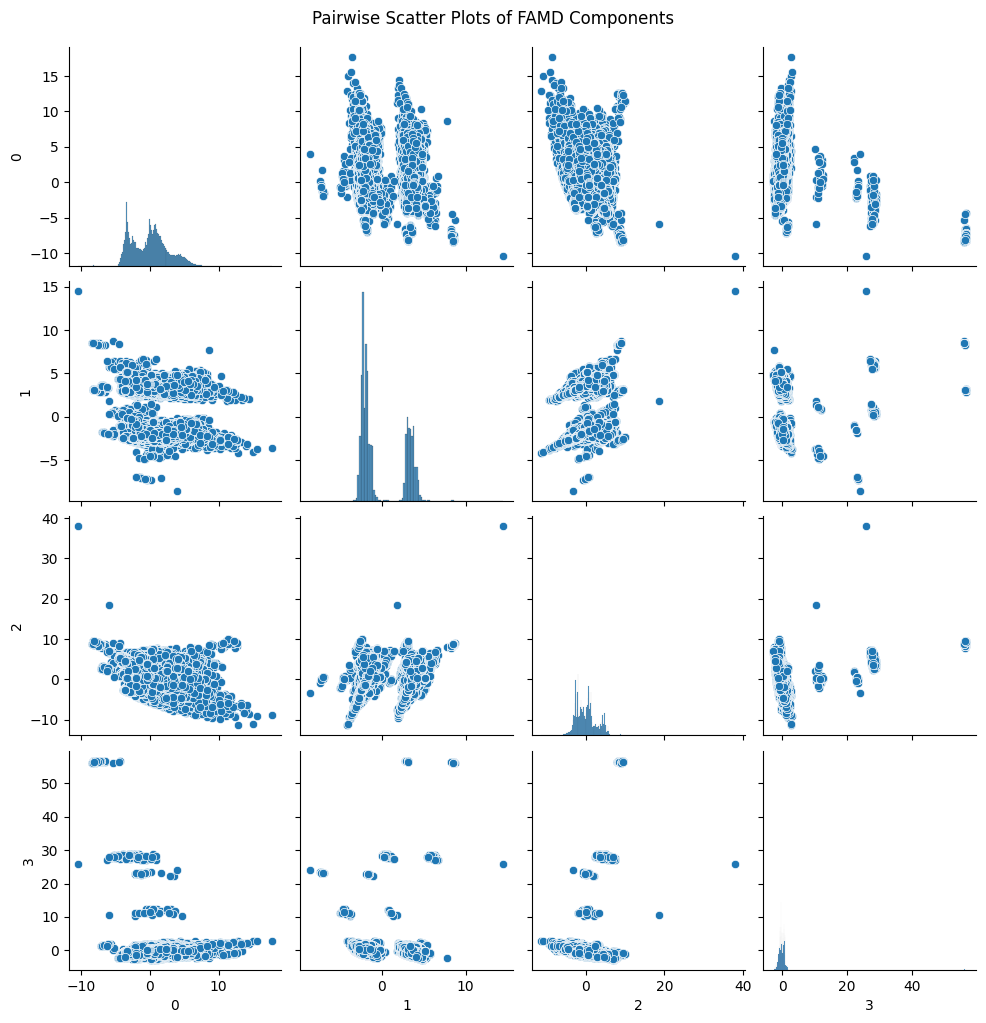

In [437]:
import pandas as pd
from prince import FAMD
import seaborn as sns
import matplotlib.pyplot as plt


famd = FAMD(n_components=4, n_iter=10,random_state=10)
famd_result = famd.fit_transform(df_famd)

# Accessing the transformed data with four components
transformed_data = famd_result.iloc[:, :4]

# Plotting pairwise scatter plots
sns.pairplot(transformed_data)
plt.suptitle('Pairwise Scatter Plots of FAMD Components', y=1.02)
plt.show()

Here we can see that depending on the components of the FAMD we want to use we will get more or less groups when we cluster the data.

We may have some things with:

Component 0 and 1,

Component 0 and 3,

Or component 1 and 2.